# Дорогой дневник

--------------------------------------------

1) Сначала я решил попробовать без генерации новых фичей и без подкрутки параметров запустить LightGBM и посмотреть, что будет. Скор 0.720
При этом пока еще нет ни генерации новых признаков, ни использования таблицы поиска и тд. Попробуем добавить.

2) Просто запускаем код из "baseline_1_pandas.ipynb" и получаем обещаный скор 0.817

3) Оптюнил 10 минут, безрезультатно. Буду придумывать новые признаки. Думаю начать с кластеризации и knn. 

4) Сначала решил просто расширить плавающее окно с 4 до 5 месяцев, результат 0.8192.

    Есть огромное количество идей, только что заменил пандас на поларс, потому что он реально на порядок быстрее. В первую очередь хочется применить знания с семинара по интерпретации бустингов, но сначала заменить катбуст на lgbm, ибо Илья утверждал, что при должном обращении он рвет и мечет.

--------------------------------------------

# Другой подход к кластеризации

Пробуем новую идею, если не получается кластеризовать все обьекты, будем делать так: мы же уже знаем какие есть кластеры, просто раздадим метки по ключевым словам, олценим сколько осталось и проведем еще одну кластеризацию. 

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from itertools import combinations

from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2

test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet')).collect()
product_information = pl.read_csv(
    os.path.join(data_path, 'cluster_product_information.csv'),
    ignore_errors=True
)

val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

val_target.group_by('target').agg(pl.count('user_id'))

target,user_id
i32,u32
0,1227381
1,647575


In [2]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для последующего создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с указанием суффиксов
combined = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined = combined.join(
        agg, 
        on='user_id', 
        how='left',
        suffix=f"_{i}"  # Добавляем уникальный суффикс для каждого соединения
    )

In [3]:
# search_aggs
id_ = 4
suf = 'search'

# Сначала вычислим value_counts отдельно и развернем их в плоскую структуру
cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров (мера разнообразия)
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров (процент повторяющихся)
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_62080\276488151.py:52: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [4]:
product_cluster_aggs = (
    actions_history
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .join(
        product_information.select('product_id', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общие агрегаты по кластерам продуктов
        pl.col('cluster').n_unique().alias('num_product_clusters'),
        pl.col('cluster').mode().first().alias('main_product_cluster'),
        
        # Аналогичные агрегаты как для search
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
        
        # Энтропия кластеров продуктов
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias('product_cluster_entropy'),
        
        # Стабильность кластеров продуктов
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias('product_cluster_stability'),
        
        # Время в основном кластере продуктов
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count()
        ).alias('main_product_cluster_time_ratio'),
            
        # Top 3 кластеров продуктов
        pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
        pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
    )
    .with_columns(
        pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
        pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
    )
    .drop(['top_product_clusters', 'top_product_counts'])
)

In [5]:
train_last_month_features = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() < val_start_date) &  # до валидации
        (pl.col('timestamp').dt.date() >= val_start_date - timedelta(days=30))  # последние 30 дней
    )
    .join(
        product_information.select('product_id', 'discount_price', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общая активность
        pl.count().alias('total_actions_30d'),
        
        # Разбивка по типам действий
        (pl.col('action_type_id') == 1).sum().alias('clicks_30d'),
        (pl.col('action_type_id') == 2).sum().alias('favorites_30d'),
        (pl.col('action_type_id') == 5).sum().alias('cart_adds_30d'),
        
        # Финансовые метрики
        pl.sum('discount_price').alias('total_spent_30d'),
        pl.mean('discount_price').alias('avg_price_30d'),
        
        # Временные характеристики (исправлено!)
        (val_start_date - pl.col('timestamp').max().dt.date()).dt.total_days().alias('days_since_last_action'),
        (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('active_days_30d'),
        
        # Метрики кластеров
        pl.col('cluster').n_unique().alias('unique_clusters_30d'),
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')
    )
    .with_columns(
        # Производные признаки
        (pl.col('total_actions_30d') / pl.col('active_days_30d')).alias('daily_actions_rate_30d'),
        (pl.col('cart_adds_30d') / pl.col('total_actions_30d')).alias('cart_add_ratio_30d'),
        (pl.col('favorites_30d') / pl.col('total_actions_30d')).alias('favorite_ratio_30d')
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_62080\1964511306.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('total_actions_30d'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_62080\1964511306.py:31: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')


In [6]:
df_main = val_target
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )

df_main = df_main.join(product_cluster_aggs, on='user_id', how='left')
df_main = df_main.join(train_last_month_features, on='user_id', how='left')
    
df_pd = df_main.to_pandas()

columns_to_log = ['max_discount_price_click', 'num_products_favorite', 'sum_discount_price_favorite', 'max_discount_price_favorite',  'num_products_order', 'sum_discount_price_order', 'sum_discount_price_order',  'num_products_to_cart', 'max_discount_price_to_cart', 'num_search', 'unique_search_queries', 'num_search_last_month', 'num_search_last_week', 'search_daily_rate', 'search_cluster_switches', 'search_mean_query_len', 'search_main_cluster_query_len_diff']

df_pd = apply_log_transform(df_pd, columns_to_log, drop_original=True)

In [7]:
#pca
from local_utils import *

pca_cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})
df_pd = add_pca_columns(df_pd,  pca_cols,  n_components = 2)

Nans filled


In [ ]:
#knn
#knn_cols = ['days_since_first_order', 'days_since_last_order', 'sum_discount_price_to_cart', 'num_products_click', 'main_search_cluster', 'search_cluster_stability', 'product_cluster_stability']

#df_pd = add_knn_features_faiss(df_pd, knn_cols, n_neighbors=5, use_gpu=True)

------------------------------------------------------------

------------------------------------------------------------

------------------------------------------------------------

------------------------------------------------------------

------------------------------------------------------------

------------------------------------------------------------

In [9]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= val_end_date)
        .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с суффиксами
combined_val = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined_val = combined_val.join(
        agg, 
        on='user_id', 
        how='outer',
        suffix=f"_{i}"
    )

C:\Users\Admin\AppData\Local\Temp\ipykernel_62080\2116881979.py:59: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  combined_val = combined_val.join(


In [10]:
id_ = 4
suf = 'search'

# Вычисляем top3 кластеров для валидации (аналогично трейну)
val_cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(val_cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_62080\555555092.py:51: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [11]:
val_product_cluster_aggs = (
    actions_history
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .join(
        product_information.select('product_id', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общие агрегаты по кластерам продуктов
        pl.col('cluster').n_unique().alias('num_product_clusters'),
        pl.col('cluster').mode().first().alias('main_product_cluster'),
        
        # Аналогичные агрегаты как для search
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
        
        # Энтропия кластеров продуктов
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias('product_cluster_entropy'),
        
        # Стабильность кластеров продуктов
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias('product_cluster_stability'),
        
        # Время в основном кластере продуктов
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count()
        ).alias('main_product_cluster_time_ratio'),
            
        # Top 3 кластеров продуктов
        pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
        pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
    )
    .with_columns(
        pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
        pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
    )
    .drop(['top_product_clusters', 'top_product_counts'])
)

In [12]:
test_last_month_features = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() < test_start_date) &  # до теста
        (pl.col('timestamp').dt.date() >= test_start_date - timedelta(days=30))  # последние 30 дней
    )
    .join(
        product_information.select('product_id', 'discount_price', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Те же метрики, что и для трейна
        pl.count().alias('total_actions_30d'),
        (pl.col('action_type_id') == 1).sum().alias('clicks_30d'),
        (pl.col('action_type_id') == 2).sum().alias('favorites_30d'),
        (pl.col('action_type_id') == 5).sum().alias('cart_adds_30d'),
        
        pl.sum('discount_price').alias('total_spent_30d'),
        pl.mean('discount_price').alias('avg_price_30d'),
        
        (test_start_date - pl.col('timestamp').max().dt.date()).dt.total_days().alias('days_since_last_action'),
        (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('active_days_30d'),
        
        pl.col('cluster').n_unique().alias('unique_clusters_30d'),
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')
    )
    .with_columns(
        (pl.col('total_actions_30d') / pl.col('active_days_30d')).alias('daily_actions_rate_30d'),
        (pl.col('cart_adds_30d') / pl.col('total_actions_30d')).alias('cart_add_ratio_30d'),
        (pl.col('favorites_30d') / pl.col('total_actions_30d')).alias('favorite_ratio_30d')
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_62080\4126633476.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('total_actions_30d'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_62080\4126633476.py:26: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')


In [13]:
from local_utils import *

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

test_df_main = test_users_submission
for _, actions_aggs_df in actions_aggs.items():
    test_df_main = (
        test_df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
test_df_main = test_df_main.join(val_product_cluster_aggs, on='user_id', how='left')
test_df_main = test_df_main.join(test_last_month_features, on='user_id', how='left')

test_df_pd = test_df_main.to_pandas()

test_df_pd = apply_log_transform(test_df_pd, columns_to_log, drop_original=True)

In [14]:
test_df_pd = add_pca_columns(test_df_pd,  pca_cols,  n_components = 2)

Nans filled


In [15]:
#test_df_pd = add_knn_features_faiss(test_df_pd, knn_cols, n_neighbors=5, use_gpu=True)

In [16]:
def add_time_pattern_features(df_pd, actions_history, product_info):
    # Конвертируем product_info в LazyFrame если нужно
    product_info_lazy = product_info.lazy() if isinstance(product_info, pl.DataFrame) else product_info
    
    time_aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .with_columns([
            ((pl.col('timestamp').dt.hour() >= 6) & (pl.col('timestamp').dt.hour() < 12)).alias('new_is_morning'),
            ((pl.col('timestamp').dt.hour() >= 12) & (pl.col('timestamp').dt.hour() < 18)).alias('new_is_day'),
            (pl.col('timestamp').dt.weekday() >= 5).alias('new_is_weekend'),
            (pl.col('timestamp').dt.hour()).alias('new_hour'),
            (pl.col('timestamp').dt.weekday()).alias('new_dow')
        ])
        .join(
            product_info_lazy.select(['product_id', 'discount_price']), 
            on='product_id',
            how='left'
        )
        .group_by('user_id')
        .agg(
            (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
            (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
            (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
            pl.col('new_hour').value_counts().struct.field('count').entropy().alias('new_hour_entropy'),
            (pl.col('new_dow').filter(pl.col('new_dow') < 5).count() / 
             (pl.col('new_dow').filter(pl.col('new_dow') >= 5).count() + 1e-6)).alias('new_weekday_weekend_ratio'),
            (pl.col('discount_price').filter(pl.col('new_is_morning')).sum() / 
            (pl.col('new_is_morning').sum() + 1e-6)).alias('new_morning_avg_spend')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(time_aggs, on='user_id', how='left')

In [17]:
def add_brand_category_features(df_pd, actions_history, product_info):
    product_info_lazy = product_info.lazy() if isinstance(product_info, pl.DataFrame) else product_info
    
    brand_aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .join(
            product_info_lazy.select(['product_id', 'brand', 'category_id', 'discount_price']),
            on='product_id',
            how='left'
        )
        .group_by('user_id')
        .agg(
            pl.col('brand').n_unique().alias('new_unique_brands'),
            (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
            pl.col('category_id').n_unique().alias('new_unique_categories'),
            pl.col('category_id').value_counts().struct.field('count').max().alias('new_favorite_category_count'),
            (pl.col('discount_price').filter(pl.col('category_id') == 
             pl.col('category_id').mode().first()).mean()).alias('new_main_category_avg_price')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(brand_aggs, on='user_id', how='left')

In [18]:
def add_search_features(df_pd, search_history):
    search_aggs = (
        search_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .with_columns([
            pl.col('search_query').str.split(' ').list.len().alias('new_query_word_count'),  # Исправлено здесь
            pl.col('search_query').str.contains(r'\d').alias('new_has_numbers')
        ])
        .group_by('user_id')
        .agg(
            pl.mean('new_query_word_count').alias('new_avg_query_length'),
            (pl.sum('new_has_numbers') / pl.count()).alias('new_numeric_query_ratio'),
            pl.col('search_query').filter(pl.col('search_query').str.len_chars() > 20).count().alias('new_long_queries_count')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(search_aggs, on='user_id', how='left')

In [19]:
# Загрузите данные заново (если нужно)
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet'))
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet'))
product_info = product_information

# Добавляем новые признаки
add_new_df_pd = add_time_pattern_features(df_pd, actions_history, product_info)
add_new_df_pd = add_brand_category_features(add_new_df_pd, actions_history, product_info) 
add_new_df_pd = add_search_features(add_new_df_pd, search_history)

add_new_df_pd

C:\Users\Admin\AppData\Local\Temp\ipykernel_62080\703708266.py:22: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_62080\703708266.py:23: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_62080\703708266.py:24: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_62080\600433880.py:15: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_62080\2438321060.py:12: Deprecat

,user_id,target,num_products_click,sum_discount_price_click,last_click_time,first_click_time,days_since_last_click,days_since_first_click,last_favorite_time,first_favorite_time,...,new_weekday_weekend_ratio,new_morning_avg_spend,new_unique_brands,new_favorite_brand_ratio,new_unique_categories,new_favorite_category_count,new_main_category_avg_price,new_avg_query_length,new_numeric_query_ratio,new_long_queries_count
0,184187,0,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaT,...,4.000000e+06,58.999971,3.0,0.500000,3.0,2.0,59.000000,1.000000,0.000000,0.0
1,8102319,1,3.0,2078.0,2024-06-03 07:02:46,2024-05-16 13:17:25,27.0,45.0,NaT,NaT,...,9.999998e-01,202.399960,5.0,0.375000,5.0,3.0,110.000000,2.166667,0.000000,1.0
2,1798707,0,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9230002,0,2.0,9847.0,2024-03-25 11:13:27,2024-03-25 11:12:59,97.0,97.0,NaT,NaT,...,2.000000e+06,4923.497538,2.0,0.500000,2.0,1.0,689.000000,NaN,NaN,NaN
4,2720573,0,NaN,NaN,NaT,NaT,NaN,NaN,2024-04-21 09:17:48,2024-04-21 09:17:48,...,0.000000e+00,702.999297,1.0,1.000000,1.0,1.0,703.000000,3.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874951,9117118,0,73.0,95433.0,2024-06-10 13:40:16,2024-03-10 06:26:09,20.0,112.0,2024-05-09 08:45:51,2024-05-09 08:42:38,...,1.484375e+00,1537.599972,73.0,0.125786,60.0,17.0,778.470588,1.824324,0.108108,9.0
1874952,5920721,0,7.0,14626.0,2024-05-15 07:08:36,2024-05-12 09:49:28,46.0,49.0,NaT,NaT,...,1.111111e-01,1583.699842,7.0,0.400000,5.0,4.0,674.750000,1.800000,0.000000,1.0
1874953,3309605,0,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1874954,9948156,0,6.0,15483.0,2024-04-13 19:31:19,2024-04-06 12:48:29,78.0,85.0,2024-04-13 19:31:28,2024-04-13 19:30:44,...,0.000000e+00,0.000000,4.0,0.333333,4.0,3.0,1789.000000,NaN,NaN,NaN


In [20]:
# Загрузите данные заново (если нужно)
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet'))
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet'))
product_info = product_information

# Добавляем новые признаки
add_new_test_df_pd = add_time_pattern_features(test_df_pd, actions_history, product_info)
add_new_test_df_pd = add_brand_category_features(add_new_test_df_pd, actions_history, product_info) 
add_new_test_df_pd = add_search_features(add_new_test_df_pd, search_history)

add_new_test_df_pd

C:\Users\Admin\AppData\Local\Temp\ipykernel_62080\703708266.py:22: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_62080\703708266.py:23: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_62080\703708266.py:24: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_62080\600433880.py:15: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_62080\2438321060.py:12: Deprecat

,user_id,num_products_click,sum_discount_price_click,last_click_time,first_click_time,days_since_last_click,days_since_first_click,last_favorite_time,first_favorite_time,days_since_last_favorite,...,new_weekday_weekend_ratio,new_morning_avg_spend,new_unique_brands,new_favorite_brand_ratio,new_unique_categories,new_favorite_category_count,new_main_category_avg_price,new_avg_query_length,new_numeric_query_ratio,new_long_queries_count
0,1342,1.0,1213.0,2024-04-21 15:03:11,2024-04-21 15:03:11,101.0,101.0,2024-04-21 15:06:25,2024-04-21 15:06:25,101.0,...,0.000000e+00,77.999922,2.0,0.666667,2.0,2.0,1213.000000,NaN,NaN,NaN
1,9852,37.0,14359.0,2024-07-11 06:51:15,2024-03-03 10:24:47,20.0,150.0,NaT,NaT,NaN,...,6.846154e-01,276.122949,54.0,0.095890,55.0,20.0,140.250000,NaN,NaN,NaN
2,10206,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,0.00,0.0
3,11317,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,0.00,1.0
4,13289,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2068419,11157283,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2068420,11160395,NaN,NaN,NaT,NaT,NaN,NaN,2024-04-16 18:42:57,2024-04-16 18:42:57,106.0,...,9.999990e-01,0.000000,2.0,0.500000,2.0,1.0,89.000000,NaN,NaN,NaN
2068421,11165052,9.0,2515.0,2024-07-25 22:37:15,2024-04-04 01:23:31,6.0,118.0,NaT,NaT,NaN,...,1.571428e+00,104.692300,9.0,0.277778,11.0,5.0,70.000000,2.350000,0.05,3.0
2068422,11168218,4.0,870.0,2024-06-27 18:48:23,2024-04-04 06:00:33,34.0,118.0,NaT,NaT,NaN,...,2.000000e+07,193.749976,4.0,0.450000,4.0,9.0,109.666667,1.857143,0.00,0.0


In [32]:
from local_utils import *

add_new_df_pd = add_new_df_pd[add_new_df_pd['user_id'] != 2346229]

lgb_tr, lgb_val = get_split(add_new_df_pd, val_size=0.25, random_state=50)

add_new_cols = list(set(add_new_df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                  'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                  'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

lgb_params = {
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.1,
        'max_depth': 7,
        'num_iterations': 300,
        'early_stopping_rounds': 100,
        'verbose': 1,
        'importance_type': 'split'
    }

lgb_model = train_model_new(lgb_tr, lgb_val, add_new_cols, 'target', params=lgb_params, shadow_features=False, sklearn_style=True)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 485921, number of negative: 920295
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14295
[LightGBM] [Info] Number of data points in the train set: 1406216, number of used features: 71
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345552 -> initscore=-0.638648
[LightGBM] [Info] Start training from score -0.638648
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.763217	valid's auc: 0.760118
[200]	train's auc: 0.765333	valid's auc: 0.76051
[300

In [38]:
import shap

explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer(lgb_val[add_new_cols])
print('features shape:', add_new_cols.shape)

print('\n\nshap values structure:')
print('.values:', shap_values.values.shape, '.base_values:', shap_values.base_values.shape, '.data:', shap_values.data.shape)
shap_values # .values - shap values, .base_values - EF(X)=среднее_предсказание, .data - наши данные

AttributeError: 'list' object has no attribute 'shape'

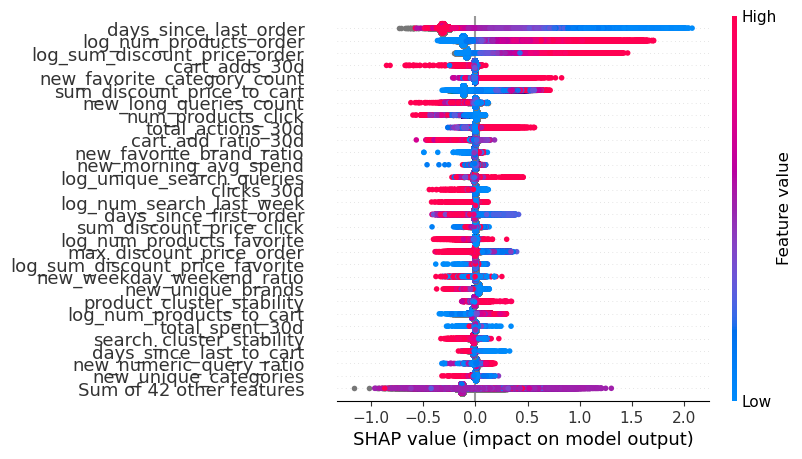

In [40]:
shap.plots.beeswarm(shap_values, max_display=30, order=shap.Explanation.abs.max(0), plot_size=(6, 5))

feature_importance: [ 38  53  38 157 228  20  97  53 198  48 131  61  45  44  62  97   4  42
 111  15 141  40  44  39  28  42  65  17  42  54  14   0  80  54  69  55
   0  89  37  58  37  85  76  37  54  30  76  54  56  83  35  59  43  71
  48  85  45  36  40  28  73 189  78  43  45  89 104 172  70 183  46] 



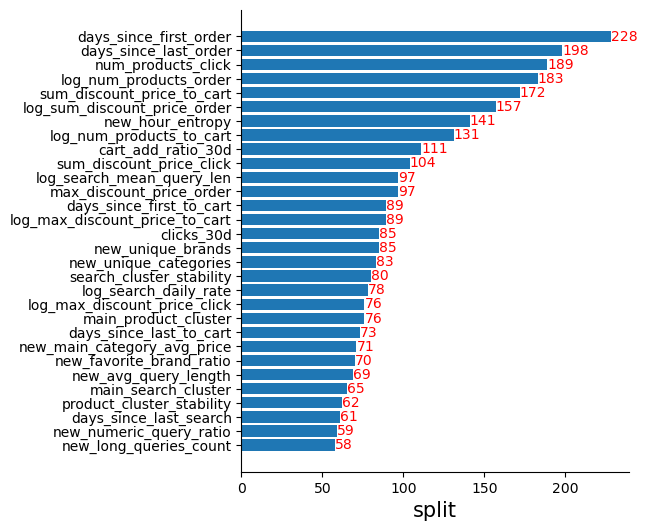

In [30]:
from local_utils import *

print('feature_importance:', lgb_model.feature_importances_, '\n')

plot_lgbm_importance(lgb_model, add_new_cols, importance_type='split', top_k=30, sklearn_style=True)

In [24]:
from local_utils import *

# Подготовка данных (аналогично вашему коду)
add_new_df_pd = add_new_df_pd[add_new_df_pd['user_id'] != 2346229]

tr, val = get_split(add_new_df_pd, val_size=0.25, random_state=45)

cols = list(set(add_new_df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

# Параметры CatBoost (аналогичные вашим LGBM параметрам)
params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': 0.01,
    'depth': 10,  # Аналог max_depth в LGBM
    'iterations': 900,
    'early_stopping_rounds': 60,
    'verbose': 1,
    'random_seed': 42,
    'thread_count': -1,  # Использовать все ядра
    'grow_policy': 'Lossguide', # Более быстрый режим роста
}

catboost_model = train_catboost_model(tr, val, cols, 'target', params=params, shadow_features=False, sklearn_style=True)

0:	test: 0.7417691	best: 0.7417691 (0)	total: 395ms	remaining: 5m 55s
100:	test: 0.7523315	best: 0.7523315 (100)	total: 26.9s	remaining: 3m 32s
200:	test: 0.7556747	best: 0.7556747 (200)	total: 55.4s	remaining: 3m 12s
300:	test: 0.7577770	best: 0.7577770 (300)	total: 1m 26s	remaining: 2m 52s
400:	test: 0.7588281	best: 0.7588281 (400)	total: 2m	remaining: 2m 29s
500:	test: 0.7594161	best: 0.7594161 (500)	total: 2m 36s	remaining: 2m 4s
600:	test: 0.7598249	best: 0.7598249 (600)	total: 3m 16s	remaining: 1m 37s
700:	test: 0.7601267	best: 0.7601267 (700)	total: 3m 53s	remaining: 1m 6s
800:	test: 0.7603478	best: 0.7603478 (800)	total: 4m 31s	remaining: 33.6s
899:	test: 0.7605081	best: 0.7605103 (898)	total: 5m 10s	remaining: 0us

bestTest = 0.760510322
bestIteration = 898

Shrink model to first 899 iterations.


feature_importance: [1.62072490e-01 1.27085756e-01 1.72567500e-01 2.15578254e+01
 6.15490098e+00 2.15894291e-01 1.28321549e+01 1.66443210e-02
 1.61771905e+01 1.65605685e-01 2.04883844e+00 1.08377201e-01
 1.07531930e-01 5.31685350e-02 2.77456608e-01 1.52534551e-01
 4.80512418e-03 2.42940502e-02 2.13775842e-01 3.57220251e-02
 3.84740641e-01 9.38834444e-03 4.62268777e-02 6.27535374e-02
 3.59019005e-02 2.75465913e-02 1.86892947e-01 1.20940345e-01
 4.37026229e-01 2.36795821e-01 1.23100734e-02 8.26736954e-02
 3.22891992e-01 4.32374214e-01 8.81546816e-02 6.19325254e-02
 2.45484718e-02 5.26435982e-01 4.96869195e-01 2.10586568e-01
 7.45543672e-03 1.85752365e-01 7.18783922e-02 1.47811057e-01
 4.06718969e-02 9.18315727e-02 1.33707639e-01 2.32145758e-02
 9.95395902e-02 2.32602534e-01 1.45529892e-02 9.61717848e-02
 5.84272518e-02 5.68108442e-02 3.19801429e-02 1.15206656e-01
 5.70153858e-02 2.90017157e-02 2.83739491e-02 4.28756317e-02
 2.77830537e-01 4.97971136e-01 6.63839736e-01 3.82575297e-01
 1.4

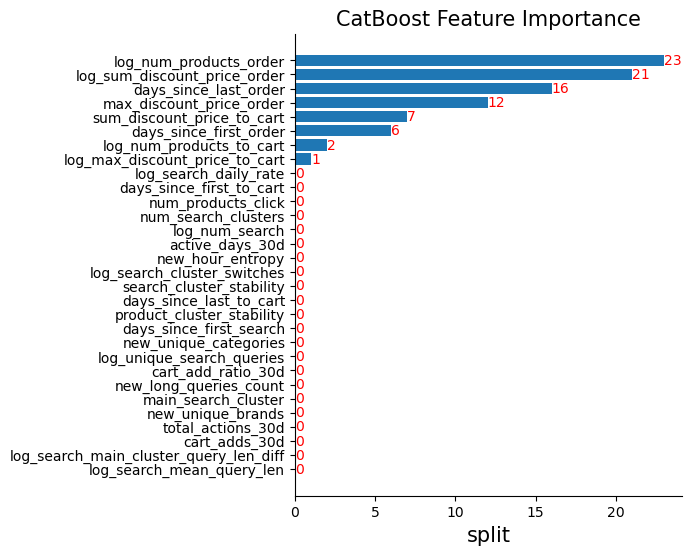

In [25]:
from local_utils import *

print('feature_importance:', catboost_model.feature_importances_, '\n')

plot_catboost_importance(catboost_model, cols, importance_type='split', top_k=30, sklearn_style=True)

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

In [35]:
#add_new_test_df_pd['catboost_predict'] = catboost_model.predict_proba(add_new_test_df_pd[cols])[:, 1]
add_new_test_df_pd['predict'] = lgb_model.predict_proba(add_new_test_df_pd[cols])[:, 1]

In [27]:
add_new_test_df_pd['predict'] = add_new_test_df_pd[['catboost_predict', 'lgb_predict']].mean(axis=1)

In [36]:
add_new_test_df_pd[['user_id', 'predict']]

,user_id,predict
0,1342,0.183558
1,9852,0.798144
2,10206,0.216792
3,11317,0.225192
4,13289,0.574736
...,...,...
2068419,11157283,0.200256
2068420,11160395,0.145491
2068421,11165052,0.599583
2068422,11168218,0.478321


In [37]:
add_new_test_df_pd[['user_id', 'predict']].to_csv('aaaaaaaaaaaaaaaaaaaa.csv', index=False)

In [ ]:
test_df_pd['catboost_predict'] = catboost_model.predict_proba(test_df_pd[cols])[:, 1]
test_df_pd['lgb_predict'] = lgb_model.predict_proba(test_df_pd[cols])[:, 1]

#test_df_pd['predict'] = model.predict(test_df_pd[cols])

In [ ]:
test_df_pd['predict'] = test_df_pd[['catboost_predict', 'lgb_predict']].mean(axis=1)

In [ ]:
test_df_pd[['user_id', 'catboost_predict', 'lgb_predict', 'predict']]

,user_id,catboost_predict,lgb_predict,predict
0,1342,0.160576,0.172984,0.166780
1,9852,0.750933,0.808319,0.779626
2,10206,0.214917,0.221423,0.218170
3,11317,0.214947,0.228265,0.221606
4,13289,0.604772,0.598704,0.601738
...,...,...,...,...
2068419,11157283,0.197924,0.200426,0.199175
2068420,11160395,0.163636,0.144137,0.153886
2068421,11165052,0.613123,0.631671,0.622397
2068422,11168218,0.555000,0.526293,0.540646


In [ ]:
test_df_pd[['user_id', 'predict']].to_csv('full_ensemble_cat_and_lgb_mean.csv', index=False)